# 環境設定

In [ ]:
# Install HappyML Library
import os

if not os.path.isdir("HappyML"):
  os.system("git clone https://github.com/cnchi/HappyML.git")

In [ ]:
from tensorflow.keras.datasets import mnist

# Load Database
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


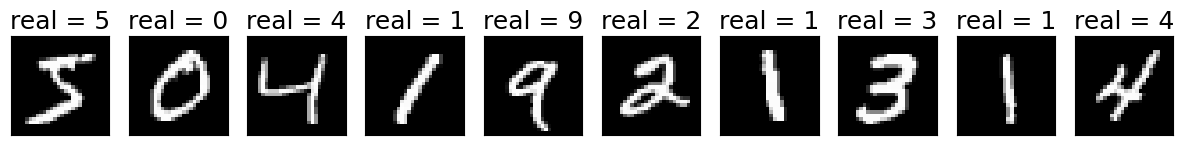

In [ ]:
# Verify Data Loaded
import HappyML.model_drawer as md

md.show_first_n_images(x_ary=X_train, y_real=Y_train, first_n=10)

# 前處理

In [ ]:
# Re-shape X from 28x28 to 784x1 (Flatten)
X_train = X_train.reshape((60000, 28*28))
X_test = X_test.reshape((10000, 28*28))

# Change Gray-scale from 0~255 to 0~1
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [ ]:
# One-Hot Encoding for Y
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# 模型校正

## 模型建立

In [ ]:
from HappyML.neural_networks import create_seq_model

# Model create
model = create_seq_model(nodes=[784, 128, 10])

## 設定 TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Remove any logs from previous runs
!rm -rf ./logs/

# Create TensorBoard log directory
import os
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Start the TensorBoard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

## 模型訓練＆校正

In [ ]:
# Train the model
model.fit(x=X_train, y=Y_train, validation_split=0.2, batch_size=10, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
4800/4800 [==============================] - 24s 4ms/step - loss: 0.2412 - acc: 0.9292 - val_loss: 0.1358 - val_acc: 0.9600
Epoch 2/20
4800/4800 [==============================] - 18s 4ms/step - loss: 0.1059 - acc: 0.9676 - val_loss: 0.1047 - val_acc: 0.9693
Epoch 3/20
4800/4800 [==============================] - 19s 4ms/step - loss: 0.0725 - acc: 0.9776 - val_loss: 0.1106 - val_acc: 0.9665
Epoch 4/20
4800/4800 [==============================] - 19s 4ms/step - loss: 0.0534 - acc: 0.9831 - val_loss: 0.0914 - val_acc: 0.9745
Epoch 5/20
4800/4800 [==============================] - 18s 4ms/step - loss: 0.0418 - acc: 0.9862 - val_loss: 0.0932 - val_acc: 0.9743
Epoch 6/20
4800/4800 [==============================] - 17s 4ms/step - loss: 0.0327 - acc: 0.9896 - val_loss: 0.0905 - val_acc: 0.9757
Epoch 7/20
4800/4800 [==============================] - 19s 4ms/step - loss: 0.0278 - acc: 0.9906 - val_loss: 0.1097 - val_acc: 0.9731
Epoch 8/20
4800/4800 [==============================] -

## 超參數組合尋優

In [ ]:
# Initializing Hyper-parameters
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

# Setup the HParams directory
hparams_dir = os.path.join(logdir, 'validation')

# Define Hyper-parameters
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64, 128]))
HP_WEIGHT_INIT = hp.HParam('kernel_initializer', hp.Discrete(["random_normal", "glorot_uniform", "glorot_normal"]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adadelta', 'rmsprop', 'adam', 'nadam']))

HPARAMS = [HP_NUM_UNITS, HP_WEIGHT_INIT, HP_OPTIMIZER]

# Set the Standard of Evaluation
METRIC_ACC = "acc"

#Creating & configuring a log file writer
with tf.summary.create_file_writer(hparams_dir).as_default():
    hp.hparams_config(
        hparams=HPARAMS,
        metrics=[hp.Metric(METRIC_ACC, display_name='ACC')]
    )

# Count the total run
total_run = 1
for p in HPARAMS:
  total_run *= len(p.domain.values)

curr_run = 1
for num_units in HP_NUM_UNITS.domain.values:
    for weight_init in HP_WEIGHT_INIT.domain.values:
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_WEIGHT_INIT: weight_init,
                HP_OPTIMIZER: optimizer
            }

            # Show somethings on Standard Output for progress
            run_name = "{} of {}".format(curr_run, total_run)
            print('--- Starting trial: {}'.format(run_name))
            print({h.name: hparams[h] for h in hparams})

            # Write information into log
            with tf.summary.create_file_writer(hparams_dir + "/" + run_name).as_default():
                hp.hparams(hparams)

                # Create & Train the model
                theNodes = [784, hparams[HP_NUM_UNITS], 10]
                model = create_seq_model(nodes=theNodes, weight_init=hparams[HP_WEIGHT_INIT], opt_name=hparams[HP_OPTIMIZER])
                model.fit(x=X_train, y=Y_train, validation_split=0.2, batch_size=10, epochs=5, callbacks=[tensorboard_callback, hp.KerasCallback(hparams_dir, hparams)])

                # Evaluate the Accuracy & Write to log
                test_loss, test_acc = model.evaluate(X_test, Y_test)
                tf.summary.scalar(METRIC_ACC, test_acc, step=10)
            curr_run += 1

--- Starting trial: 1 of 36
{'num_units': 32, 'kernel_initializer': 'glorot_normal', 'optimizer': 'adadelta'}
Epoch 1/5
4800/4800 [==============================] - 27s 6ms/step - loss: 2.2730 - acc: 0.1341 - val_loss: 2.2226 - val_acc: 0.1669
Epoch 2/5
4800/4800 [==============================] - 28s 6ms/step - loss: 2.1893 - acc: 0.2049 - val_loss: 2.1392 - val_acc: 0.2520
Epoch 3/5
4800/4800 [==============================] - 28s 6ms/step - loss: 2.1077 - acc: 0.2892 - val_loss: 2.0544 - val_acc: 0.3488
Epoch 4/5
4800/4800 [==============================] - 27s 6ms/step - loss: 2.0224 - acc: 0.3842 - val_loss: 1.9651 - val_acc: 0.4541
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 1.8819 - acc: 0.5249
--- Starting trial: 2 of 36
{'num_units': 32, 'kernel_initializer': 'glorot_normal', 'optimizer': 'adam'}
Epoch 1/5
4800/4800 [==============================] - 29s 6ms/step - loss: 0.3114 - acc: 0.9115 - val_loss: 0.1899 - val_acc: 0.9467
Epoch 2/5
4800/4800 

# 依照最優解建立、訓練模型

In [ ]:
# Model create
model = create_seq_model(nodes=[784, 128, 10], weight_init="glorot_normal", opt_name="rmsprop")

# Train the model
model.fit(x=X_train, y=Y_train, validation_split=0.2, batch_size=10, epochs=5)

Epoch 1/5
4800/4800 [==============================] - 18s 4ms/step - loss: 0.2545 - acc: 0.9251 - val_loss: 0.1641 - val_acc: 0.9559
Epoch 2/5
4800/4800 [==============================] - 15s 3ms/step - loss: 0.1304 - acc: 0.9643 - val_loss: 0.1331 - val_acc: 0.9647
Epoch 3/5
4800/4800 [==============================] - 15s 3ms/step - loss: 0.1011 - acc: 0.9732 - val_loss: 0.1231 - val_acc: 0.9715
Epoch 4/5
4800/4800 [==============================] - 15s 3ms/step - loss: 0.0850 - acc: 0.9769 - val_loss: 0.1260 - val_acc: 0.9708
Epoch 5/5
4800/4800 [==============================] - 16s 3ms/step - loss: 0.0731 - acc: 0.9810 - val_loss: 0.1386 - val_acc: 0.9696


# 模型評估

In [ ]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Accuracy of Testing Set:", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1197 - acc: 0.9725
Accuracy of Testing Set: 0.9725000262260437


# 預測答案

In [ ]:
import numpy as np

# Predict the answer
Y_pred = np.argmax(model.predict(X_test), axis=1)

313/313 [==============================] - 1s 2ms/step


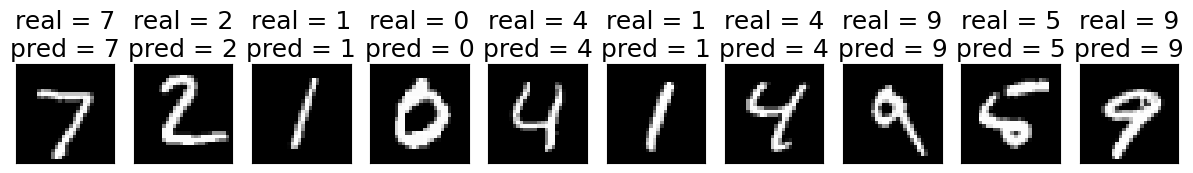

In [ ]:
# Reload the pictures & show the answer vs. prediction
(x_train, y_train), (x_test, y_test) = mnist.load_data()
md.show_first_n_images(x_ary=x_test, y_real=y_test, y_pred=Y_pred, first_n=10)